<a href="https://colab.research.google.com/github/tanvircr7/meh/blob/master/ViT_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [37]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [38]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

**GET DATA**

In [39]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [40]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

**DATASETS == DATALOADERS**

In [41]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [42]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE,
)
len(train_dataloader), test_dataloader, class_names

(8,
 ['pizza', 'steak', 'sushi'])

In [43]:
# visualize single image
img, label = next(iter(train_dataloader))
# Display the image
# plt.imshow(img) # ERROR: C H W vs H W C
# plt.axis('off')  # Optional: Turn off axes for better visualization
# plt.show()
img[0], label[0]

(tensor([[[0.5490, 0.3843, 0.2706,  ..., 0.4196, 0.4118, 0.3725],
          [0.2941, 0.2039, 0.2157,  ..., 0.4431, 0.4157, 0.3686],
          [0.1804, 0.1569, 0.1922,  ..., 0.4353, 0.4353, 0.4039],
          ...,
          [0.2118, 0.1686, 0.1490,  ..., 0.2941, 0.2588, 0.2235],
          [0.1490, 0.1216, 0.1176,  ..., 0.3569, 0.2196, 0.2275],
          [0.1490, 0.1176, 0.1098,  ..., 0.5294, 0.2510, 0.2078]],
 
         [[0.4667, 0.2980, 0.1765,  ..., 0.2157, 0.2157, 0.1765],
          [0.2157, 0.1176, 0.1216,  ..., 0.2314, 0.2118, 0.1686],
          [0.1059, 0.0784, 0.1020,  ..., 0.2235, 0.2235, 0.1922],
          ...,
          [0.1255, 0.0863, 0.0745,  ..., 0.1686, 0.1373, 0.1020],
          [0.0745, 0.0510, 0.0471,  ..., 0.2431, 0.1137, 0.1216],
          [0.0784, 0.0510, 0.0431,  ..., 0.4196, 0.1451, 0.1098]],
 
         [[0.4667, 0.2902, 0.1569,  ..., 0.1804, 0.1765, 0.1373],
          [0.2039, 0.1020, 0.0902,  ..., 0.2157, 0.1922, 0.1451],
          [0.0863, 0.0549, 0.0627,  ...,

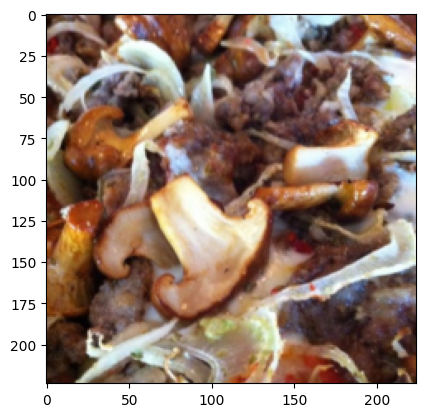

In [44]:
import torchvision.transforms as T

# Assuming img is a tensor in the form [C, H, W] (channel-first)
# Convert it to a NumPy array in [H, W, C] format
img_np = T.ToPILImage()(img[0]).convert("RGB")
# img_np = img[0].permute(1,2,0)
plt.imshow(img_np)

# **4. EQUATION 1**

In [45]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [46]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


# 4.2 Turning a single image into patches

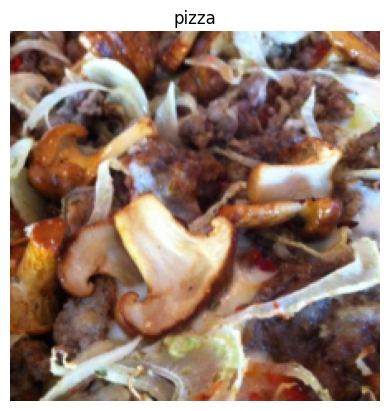

In [47]:
# View single img
import matplotlib.pyplot as plt
image = img[0]
label = label[0]
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

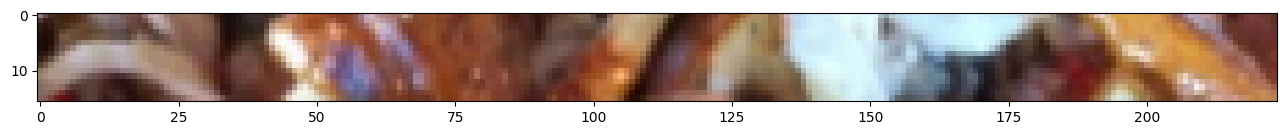

In [48]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels
0: 0
1: 16
2: 32
3: 48
4: 64
5: 80
6: 96
7: 112
8: 128
9: 144
10: 160
11: 176
12: 192
13: 208


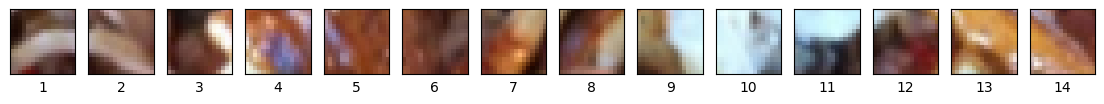

In [49]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    print(f"{i}: {patch}")
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


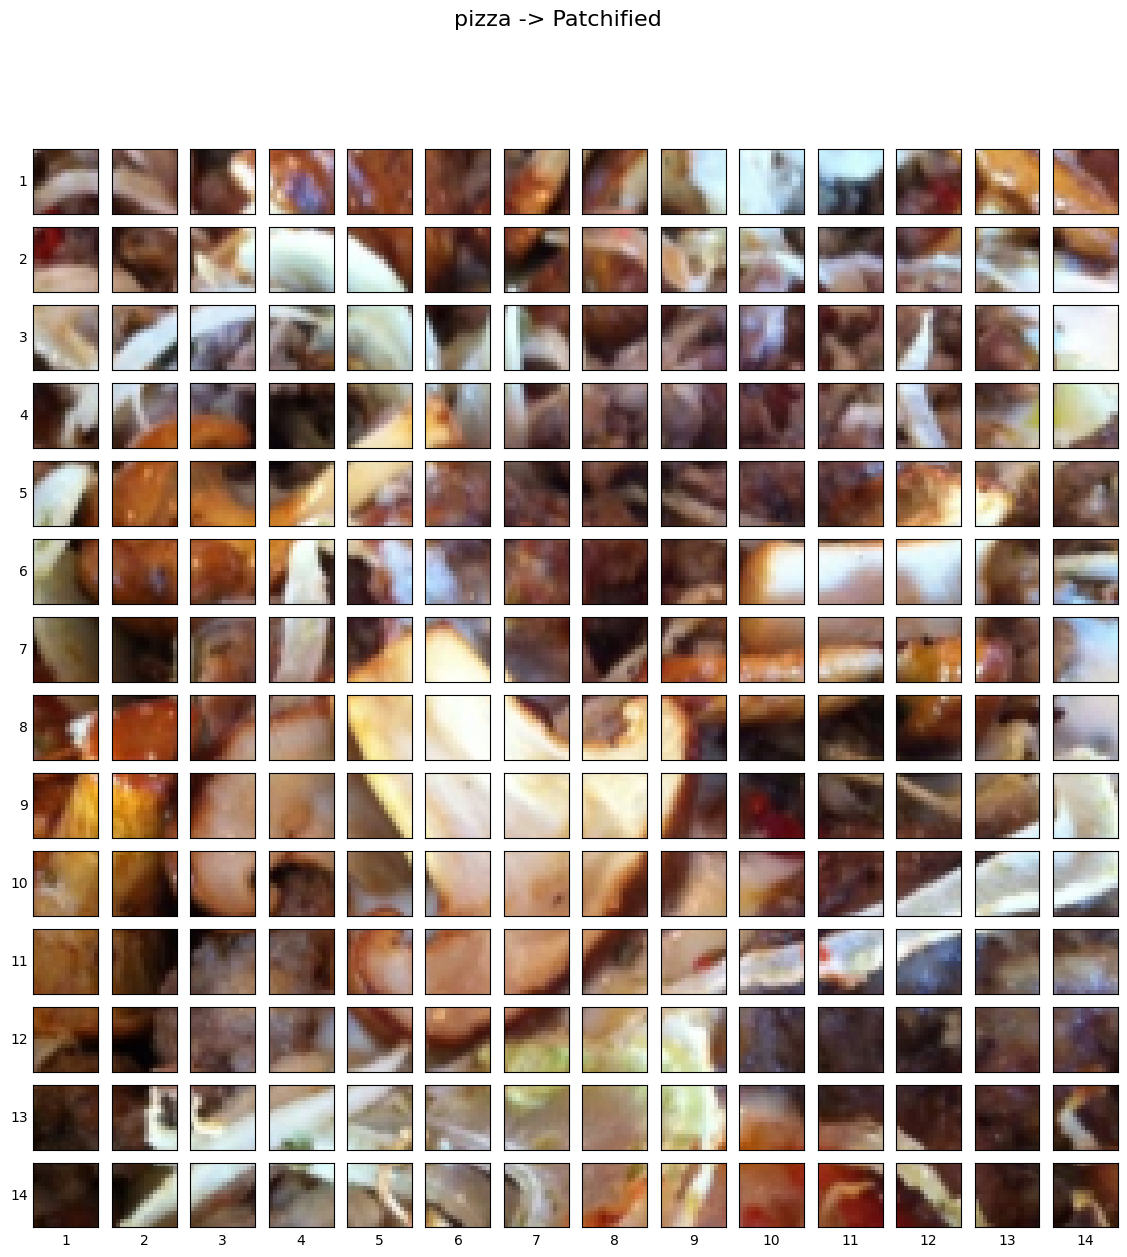

In [50]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

# **4.3 Conv2d**

In [51]:
from torch import nn
patch_size = 16
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

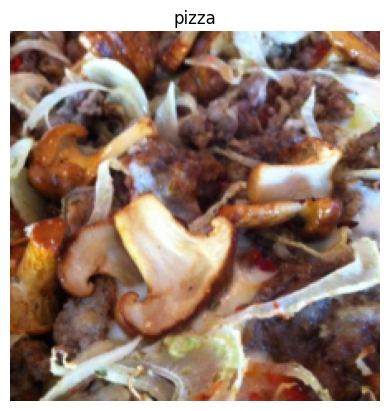

In [52]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [53]:
output_conv_image = conv2d(image.unsqueeze(dim=0))
print(f"Output shape: {output_conv_image.shape}")
# print(output.shape)
# output

Output shape: torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [215, 101, 90, 596, 347]


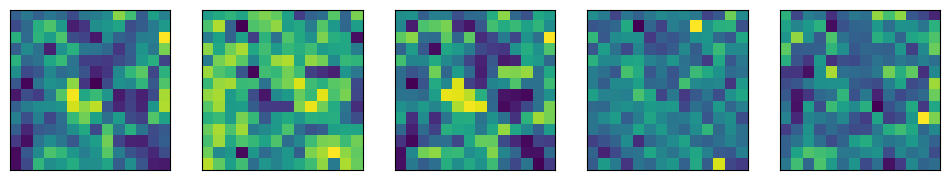

In [54]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 768), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = output_conv_image[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

# **4.4 Flattening**

In [55]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


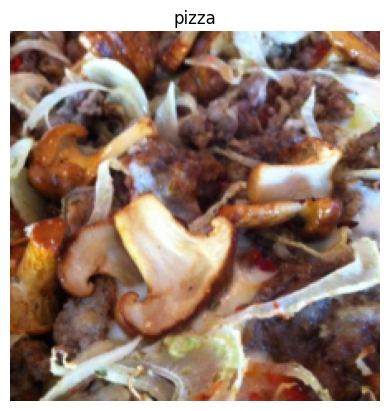

In [56]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [57]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


**We've now matched the desired input and output shapes for the patch embedding layer of the ViT architecture using a couple of PyTorch layers.**

How about we visualize one of the flattened feature maps?

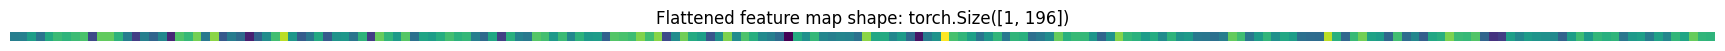

In [58]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [59]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-2.2182e-01, -2.1425e-01, -1.1948e-01, -2.5412e-01, -8.1987e-02,
          -2.5023e-02, -4.9295e-02, -2.2588e-02,  3.8685e-03, -3.8390e-01,
           3.5048e-02,  3.7972e-02, -5.2992e-02, -2.2919e-01, -4.1080e-01,
          -2.1982e-01, -3.0419e-01, -1.9400e-01, -4.6965e-01,  9.6180e-03,
          -3.2748e-02,  5.9508e-02, -2.3975e-01,  8.7269e-02, -3.3716e-01,
          -2.2656e-01, -2.8601e-01, -4.8733e-01, -3.0962e-01, -1.7278e-01,
          -1.1565e-02,  1.4370e-01, -1.4298e-01, -3.2879e-01, -2.4647e-01,
          -8.2171e-02, -3.3106e-01, -1.5346e-01, -1.4250e-01, -2.5099e-01,
          -4.7982e-02, -4.1722e-01,  4.2600e-02, -4.1884e-02, -1.3048e-01,
           1.7134e-02, -2.6378e-01, -1.0022e-01, -1.2236e-01, -7.0408e-02,
          -7.9440e-03, -5.4476e-02, -3.6731e-02, -2.2286e-01, -2.8544e-01,
          -9.1267e-02, -4.0576e-01, -6.0288e-02, -2.0856e-01, -2.3985e-01,
           1.8780e-02, -9.6869e-03, -1.3603e-01, -2.3374e-02, -1.9096e-01,
          -5.1528e-02, -1

# **4.5 Turning the ViT patch embedding layer into a PyTorch module**

Specifically we'll:

1.   Create a class called PatchEmbedding which subclasses nn.Module (so it can be used a PyTorch layer).
2.   Initialize the class with the parameters in_channels=3, patch_size=16 (for ViT-Base) and embedding_dim=768 (this is $D$ for ViT-Base from Table 1).
3. Create a layer to turn an image into patches using nn.Conv2d() (just like in 4.3 above).
4. Create a layer to flatten the patch feature maps into a single dimension (just like in 4.4 above).
5. Define a forward() method to take an input and pass it through the layers created in 3 and 4.
6. Make sure the output shape reflects the required output shape of the ViT architecture
(${N \times\left(P^{2} \cdot C\right)}$)






In [60]:
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels=3, patch_size=16, embedding_dim=768):
    super().__init__()
    self.patch_size = patch_size
    self.conv2d_layer = nn.Conv2d(in_channels=in_channels,
                           out_channels=embedding_dim,
                           kernel_size=patch_size,
                           stride=patch_size,
                           padding=0)
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

  def forward(self, input):
    # Create assertion to check that inputs are the correct shape
    image_resolution = input.shape[-1]
    assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

    image = input
    print(f"[INFO] Image shape {image.shape}")
    temp = self.conv2d_layer(image.unsqueeze(0))
    temp2 = self.flatten(temp)
    print(f"[INFO] final shape {temp2.shape}")
    temp3 = temp2.permute(0,2,1)
    return temp3

In [61]:
model = PatchEmbedding()
model

PatchEmbedding(
  (conv2d_layer): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (flatten): Flatten(start_dim=2, end_dim=3)
)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])
------ with Model --------
[INFO] Image shape torch.Size([3, 224, 224])
[INFO] final shape torch.Size([1, 768, 196])
Flattened image feature map shape: torch.Size([1, 196, 768])


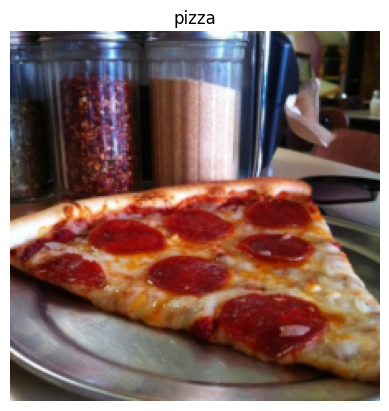

In [62]:
img, label = next(iter(train_dataloader))

# View single img
import matplotlib.pyplot as plt

image = img[1]
label = label[1]
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")


print(f"------ with Model --------")

# 2. Turn image into feature maps
image_out_of_model = model(image)
print(f"Flattened image feature map shape: {image_out_of_model.shape}")

In [63]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
[INFO] Image shape torch.Size([3, 224, 224])
[INFO] final shape torch.Size([1, 768, 196])
Output patch embedding shape: torch.Size([1, 196, 768])


In [64]:
# Create random input sizes
# random_input_image = (1, 3, 224, 224)
random_input_image = (3, 224, 224)
# random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size
random_input_image_error = (3, 250, 250) # will error because image size is incompatible with patch_size

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

[INFO] Image shape torch.Size([3, 224, 224])
[INFO] final shape torch.Size([1, 768, 196])


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [3, 224, 224]        [1, 196, 768]        --                   True
├─Conv2d (conv2d_layer)                  [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

# **4.6 Creating the class token embedding**

In [65]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.2074, -0.1375, -0.1208,  ...,  0.1601, -0.1834,  0.2238],
         [-0.2933,  0.0617, -0.1270,  ...,  0.1887, -0.0210,  0.0562],
         [-0.2261,  0.0680, -0.0855,  ...,  0.1759, -0.0807,  0.0865],
         ...,
         [-0.3421,  0.0533, -0.1906,  ...,  0.2012, -0.0500,  0.1973],
         [-0.3252,  0.0593, -0.2030,  ...,  0.2047, -0.0696,  0.1434],
         [-0.2129,  0.0206, -0.2308,  ...,  0.1335,  0.0009,  0.1901]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [66]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(data=torch.ones(1,1,768), requires_grad=True) # Why not torch.randn?
# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [67]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [-2.0745e-01, -1.3747e-01, -1.2084e-01,  ...,  1.6012e-01,
          -1.8340e-01,  2.2381e-01],
         [-2.9327e-01,  6.1658e-02, -1.2702e-01,  ...,  1.8873e-01,
          -2.0976e-02,  5.6191e-02],
         ...,
         [-3.4210e-01,  5.3266e-02, -1.9055e-01,  ...,  2.0122e-01,
          -5.0025e-02,  1.9731e-01],
         [-3.2516e-01,  5.9344e-02, -2.0297e-01,  ...,  2.0466e-01,
          -6.9599e-02,  1.4335e-01],
         [-2.1291e-01,  2.0638e-02, -2.3078e-01,  ...,  1.3355e-01,
           9.2060e-04,  1.9013e-01]]], grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


# **4.7 Creating the position embedding**

In [68]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [69]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.7926, 0.8625, 0.8792,  ..., 1.1601, 0.8166, 1.2238],
         [0.7067, 1.0617, 0.8730,  ..., 1.1887, 0.9790, 1.0562],
         ...,
         [0.6579, 1.0533, 0.8094,  ..., 1.2012, 0.9500, 1.1973],
         [0.6748, 1.0593, 0.7970,  ..., 1.2047, 0.9304, 1.1434],
         [0.7871, 1.0206, 0.7692,  ..., 1.1335, 1.0009, 1.1901]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


# **4.8 Putting it all together: from image to embedding**


# **5. Equation 2: Multi-Head Attention (MSA)**


1.   Create a class called MultiheadSelfAttentionBlock that inherits from torch.nn.Module.
2.   Initialize the class with hyperparameters from Table 1 of the ViT paper for the ViT-Base model.
3. Create a layer normalization (LN) layer with torch.nn.LayerNorm() with the normalized_shape parameter the same as our embedding dimension ($D$ from Table 1).
4. Create a multi-head attention (MSA) layer with the appropriate embed_dim, num_heads, dropout and batch_first parameters.
5. Create a forward() method for our class passing the in the inputs through the LN layer and MSA layer.



# **5.3 Replicating Equation 2 with PyTorch layers**

In [75]:
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self, num_heads=12, dropout=0, embedding_dim=768):
    super().__init__()

    self.attention_layer = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, dropout=dropout, batch_first=True)

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

  def forward(self, input):
    tmp = self.layer_norm(input)
    query, key, value = tmp, tmp, tmp
    attn_output, _ = self.attention_layer(query, key, value, need_weights=False)
    return attn_output

In [78]:
msa_model = MultiHeadSelfAttentionBlock()
res = msa_model(patch_and_position_embedding)
res, res.shape

(tensor([[[ 0.5612, -0.3766, -0.0013,  ...,  0.1833, -0.3883, -0.1294],
          [ 0.5593, -0.3581,  0.0129,  ...,  0.1658, -0.3724, -0.1321],
          [ 0.5725, -0.3572,  0.0069,  ...,  0.1723, -0.3807, -0.1295],
          ...,
          [ 0.5658, -0.3550,  0.0030,  ...,  0.1672, -0.3801, -0.1359],
          [ 0.5645, -0.3565,  0.0021,  ...,  0.1642, -0.3829, -0.1344],
          [ 0.5651, -0.3582,  0.0084,  ...,  0.1577, -0.3814, -0.1296]]],
        grad_fn=<TransposeBackward0>),
 torch.Size([1, 197, 768]))

In [81]:
res == patch_and_position_embedding

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])

# **6. Equation 3: Multilayer Perceptron (MLP)**

In [ ]:
class MLP(nn.Module):
  def __init__(self, embedding_dim=768, ):
    super().__init__()

    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)


  def forward(self, input):


    return